<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/PNNPPV/notebooky/cv10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10. cvičenie - VAE a StyleTransfer

Na tomto cvičení si ukážeme VAE (variational autoencoder), a metódu style transfer.

## VAE - princíp

VEA funguje na princípe enkódera a dekódera. Enkódujeme pôvodný obraz, resp. iný vstup do tzv. latentného priestoru. To nám umožňuje vytvoriť redukciu viacrozmerných dát do menšej dimenzie. Dekóder potom dokáže na vstupe zobrať tieto vektory a vygenerovať pôvodný obraz. Toto sa dá využiť napríklad na generáciu obrázkov z distribúcie datasetu.

Enkóder skonštruujeme ako neurónovú sieť, ktorá vráti parametre distribúcie $q_\theta (z | x)$. Z tejto distribúcie môžeme vybrať vzorku $z$. Túto distribúciu budeme modelovať ako normálnu distribúciu a $\theta$ teda bude reprezentovať parametre $\mu$ a $\sigma$. Teda priemer a stredná odchylka.

Dekóder je potom sieť ktorá na vstup prijme vektor $z$ a na výstupe nám generuje distribúciu $q_\phi (x | z)$. Túto distribúciu potom trénujeme pomocou tzv. max likelihood voči trénovacím dátam. Teda pre $i$-ty príklad z trénovacej množiny. $$C = - \mathbb{E}_{z \sim q_\theta(z|x_i)} log(p_\phi (x_i | z))$$

Prakticky je maximalizácia log-likelihood ekvivalentná s minimalizáciou cross-entropy, alebo inej metriky podľa toho čo predpokladáme o distribúcii $p_\phi$.

Takáto optimalizácia však nestačí. Potrebujeme ešte zabezpečiť aby rozdelenie v latentnom priestore bolo zmysluplné. To zabezpečíme pridaním regularizačného člena tzv. Kullback-Leiblerovej divergenice. Táto metrika nám umožňuje spočítať ako veľmi podobné sú dve rôzne distribúcie. Náš cieľ bude aby distribúcia $q_\theta$ bola čo najbližšia normálnej distribúcii $p(z)$. Teoretické zdôvodnenie môžete nájsť [tu](https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/), alebo [tu](https://arxiv.org/pdf/1907.08956.pdf).


$$ C = - \mathbb{E}_{\vec{z} \sim q_\theta(z|\vec{x}_i)} log(p_\phi (\vec{x}_i | \vec{z})) + D_{KL}(q_\theta(\vec{z}|\vec{x}_i) ~||~ p(\vec{z}))$$

$$ D_{KL}(q_\theta(\vec{z}|\vec{x}) ~||~ p(\vec{z})) = \mathbb{E}\left[log(q_\theta(\vec{z}|\vec{x})) - log(p(\vec{z}))\right]$$.

Uvažujeme [normálne distribúcie](https://en.wikipedia.org/wiki/Multivariate_normal_distribution):

$$q_\theta(\vec{z}|\vec{x}) = N(\vec{\mu}, \Sigma),~p(\vec{z}) = N(\vec{0},\mathbb{I})$$, $$\Sigma = diag(\sigma_1^2, \sigma_2^2, ..., \sigma_k^2)$$

$$N(\vec{\mu},\Sigma) = \frac{e^{-\frac{1}{2}(\vec{x} - \vec\mu)^T\Sigma^{-1}(\vec{x} - \vec\mu)}}{\sqrt{2 \pi |\Sigma|}}$$

Pre KL divergenciu normálnych distribúcii [platí](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence):


$$D_{KL}(N(\vec\mu_0, \Sigma_0) || N(\vec\mu_1, \Sigma_1)) = \frac{1}{2} \left( tr(\Sigma_1^{-1} \Sigma_0) + (\vec\mu_1 - \vec\mu_0)^T \Sigma_1^{-1}(\vec\mu_1-\vec\mu_0) - k + ln \frac{|\Sigma_1|}{|\Sigma_0|}\right)$$

Teda:

$$D_{KL}(q_\theta(\vec{z}|\vec{x}) ~||~ p(\vec{z})) = \frac{1}{2}\left( \sum_{i=1}^k \sigma_i + \sum_{i=1}^k \mu_i^2 - k + log\prod_{i=1}^k \frac{1}{\sigma_i^2} \right)$$

$$D_{KL}(q_\theta(\vec{z}|\vec{x}) ~||~ p(\vec{z})) = \frac{1}{2}\sum_{i=1}^k \left(\sigma_i^2 + \mu_i^2 - 1 - log(\sigma_i^2) \right)$$

Z numerických dôvodov je lepšie pracovať v sieti priamo s $log(\sigma_i^2)$ namiesto s $\sigma_i^2$. Ak si zadefinujeme:

$$\lambda_i = log(\sigma_i^2)$$

potom konečne:

$$D_{KL}(q_\theta(\vec{z}|\vec{x}) ~||~ p(\vec{z})) = \frac{1}{2}\sum_{i=1}^k \left(e^{\lambda_i} + \mu_i^2 - 1 - \lambda_i \right)$$


## Ako to teda celé bude fungovať?

$\vec\mu$ aj $\vec\lambda$ sa počítajú na základe prvkov $\vec{x}_i$ v minibatchi. Tj. enkóder (sieť) zoberie na vstupe $\vec{x}_i$ a z neho spočíta $\vec{\mu}$ a $\vec\lambda$. Na základe toho sa ako $\vec{z}$ vyberie vzorka z distribúcie $N(\vec{\mu}, \Sigma)$. Tá sa potom vloží do enkódera (opäť sieť) a dostaneme výsledok $\vec{y}$. Sieť potom trénujeme na minibatchi veľkosti $M$ pomocou loss napr. pomocou cross-entropy:

$$ C = \frac{1}{M} \sum_{i = 1}^M CE\left(\vec{y}(\vec{z} \sim N[\vec{\mu}(\vec{x}_i), \Sigma(\vec{x}_i)]), \vec{x}_i \right) + D_{KL}(\vec{\mu}(\vec{x}_i), \Sigma(\vec{x}_i)) $$ 

Posledná vec, ktorú musíme vyriešiť je ako budeme vyberať vzorky $vec{z}$ z distribúcie $N(\vec{\mu}(\vec{x}_i), \Sigma(\vec{x}_i))$ tak, aby sa nám gradienty spropagovali aj do dekódera. Naštastie sa to dá spraviť pomocou vyberania vzoriek z bežnej normálnej distribúcie:

$$ z_j = \mu_j + \sigma_j \cdot N(0,1) = \mu_j + e^{\frac{\lambda_j}{2}} \cdot N(0,1)$$ 

## Diagram VAE

Teraz budete implementovať sieť podľa tohoto diagramu:

![Alt text](https://raw.githubusercontent.com/kocurvik/edu/master/PNNPPV/supplementary/ntb_images/VAE_MNIST_small.png)

Máme v podstate tri modely, ktoré zdieaľajú niektoré vrstvy. Na konci samozrejme budete musieť trénovať len VAE model a tie ostatné dva môžete použiť neskôr na inferenciu.

Vrstvu ktorá vráti z napíšte tak pomocou tzv. Lambda layer z kerasu. Jej využitie si pozrite v dokumentácii. V diagrame máme aj "vrstvu" random_normal. Tú však neimplementuje ako samostatnú vrstvu ale súčasť Lambda vrstvy!

In [0]:
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.layers import Dense, Lambda, Input
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


Tradične si načítame MNIST.

In [0]:
(x, y), (x_test, y_test) = mnist.load_data()
x = np.reshape(x, [60000, 784]) / 255
x_test = np.reshape(x_test, [10000, 784]) / 255

11493376/11490434 [==============================] - 2s 0us/step


Nastavíme parametre modelu.

In [0]:
n_z = 2
n_hidden = 512
batch_size = 32

Tu doplnte váš kód.

In [0]:
### Kód pre VAE

Po natrénovaní modelu by váš dekóder mal byť schopný generovať obrázky čísiel. Vždy keď spustíte nasledujúcu bunku by ste mali vidieť niečo iné.

[[-0.33066022  0.22481317]]


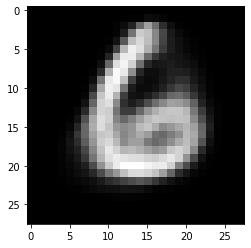

In [0]:
z_example = np.random.randn(1,2)
print(z_example)
prediction = decoder_model.predict(z_example)
plt.imshow(np.reshape(prediction[0], [28, 28]), cmap='gray')
plt.show()

Môžeme si aj zobraziť ako sú rozložené čísla z testovacej množiny v latentnom priestore. Tu by sme očakávali, že jednotlivé čísla budú v clusteroch pri sebe. A distribúcia všetkých bodov sa bude podobať tej normálnej.

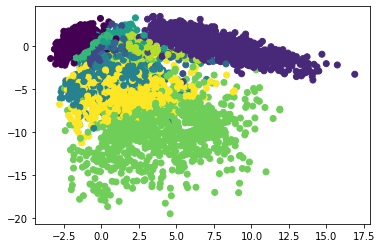

In [0]:
for i in range(10000//32):
  prediction = encoder_model.predict(x_test[i*32:(i+1)*32, :])
  if i == 0:
    z_list = prediction
  else:
    z_list = np.row_stack([z_list, prediction])

plt.scatter(z_list[:, 0], z_list[:, 1], c = y_test[:len(z_list)])
plt.show()

Podobne to môžeme skúsiť aj na trénovacej množine.

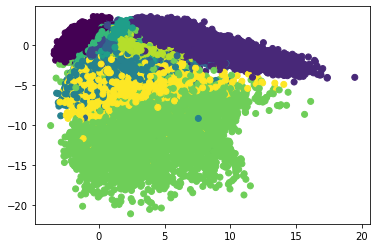

In [0]:
for i in range(60000//32):
  prediction = encoder_model.predict(x[i*32:(i+1)*32, :])
  if i == 0:
    z_list = prediction
  else:
    z_list = np.row_stack([z_list, prediction])

plt.scatter(z_list[:, 0], z_list[:, 1], c = y[:len(z_list)])
plt.show()

Tento skript nám zobrazí ako sa mení výstup z množiny v latentnom priestore.

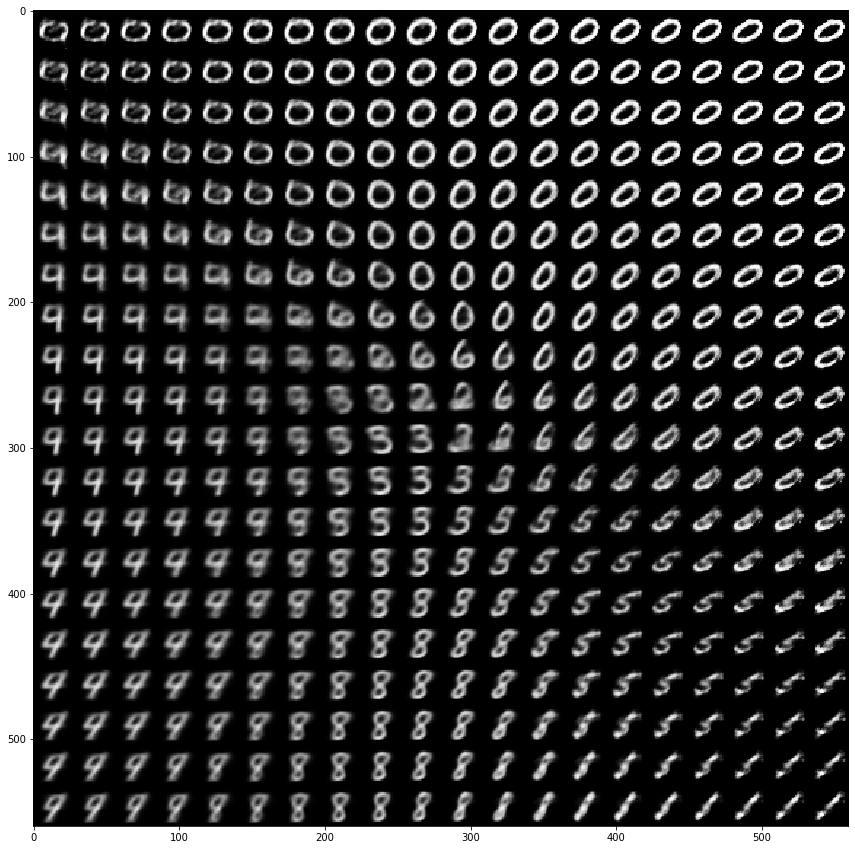

In [0]:
n_images = 20

final_image = np.zeros([28*n_images,28*n_images])

for i, z1 in enumerate(np.linspace(-3, 3, n_images)):
  for j, z2 in enumerate(np.linspace(-3, 3, n_images)):
    prediction = decoder_model.predict(np.array([[z1, z2]]))
    final_image[i*28:(i+1)*28, j*28:(j+1)*28] = np.reshape(prediction[0], [28, 28])

plt.figure(figsize = (15, 15))
plt.imshow(final_image, cmap='gray')
plt.show()